<img src="agent_loop.png" width="700"/>

<img src="simpleagent.png" width="700"/>

In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.agents import tool


@tool
def reverse_text(text: str) -> str:
    """Reverses the input text."""
    return text[::-1]

tools = [
    TavilySearchResults(max_results=2),
    reverse_text
]

Add visualization for possible tools

In [2]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

In [3]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

In [4]:
from langchain_core.utils.function_calling import convert_to_openai_function

functions = [convert_to_openai_function(t) for t in tools]

In [8]:
print(functions[0])

{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query']}}


In [9]:
model = model.bind_functions(functions)

In [11]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state['messages']
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"
    
# Define the function that calls the model
def call_model(state):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function to execute tools
def call_tool(state):
    messages = state['messages']
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(last_message.additional_kwargs["function_call"]["arguments"]),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

In [12]:
from langgraph.graph import StateGraph, END
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edges
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END
    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge('action', 'agent')

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

In [18]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="Who is the current president of the Armenia? Please reverse the name")]}
app.invoke(inputs)

{'messages': [HumanMessage(content='Who is the current president of the Armenia? Please reverse the name'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"current president of Armenia"}', 'name': 'tavily_search_results_json'}}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 125, 'total_tokens': 146}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'function_call', 'logprobs': None}),
  FunctionMessage(content='[{\'url\': \'https://en.wikipedia.org/wiki/President_of_Armenia\', \'content\': \'If the Constitutional Court concludes that there are no grounds for impeaching the president of the Republic the impeachment is removed from the agenda of the National Assembly.\\nHealth issues[edit]\\nIn case of serious illness of the president of the Republic or other insurmountable obstacles which make it impossible for the President to perform their responsibilities, the National Assembly, 

In [19]:
from langchain_core.output_parsers import StrOutputParser

str_output_parser = StrOutputParser()

In [20]:
from langchain_core.runnables import RunnableLambda

def extract_output(result):
    return result["messages"][-1]

final_chain = app | RunnableLambda(extract_output) | str_output_parser
final_chain.invoke(inputs)

'The reversed name of the current president of Armenia, Vahagn Khachaturyan, is "nayrutahcahK ngahaV".'

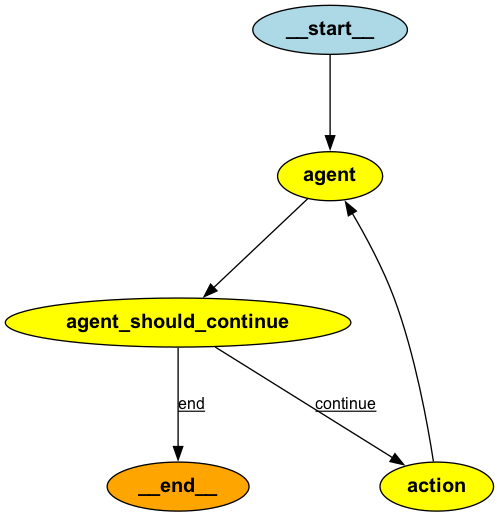

In [21]:
from IPython.display import Image
Image(app.get_graph().draw_png())